**This code can simulate differential outer coil LVDT signals with transversal offsets of the inner coil. New LVDT designs can be loaded in the "feed.py" script, furthermore, different wire gauges are added in the "design.py" script. Additionally,all code has been set up to save the data in the following Folder hierarchy:**
* Codemap (MIIJ)
* dataMap
    - bFields
    - flux
    - voltages
    - TransDev

**This can of course all be changed by specifying other folders in the commands, but the example code will continue using this convention. When the desired LVDT design and wire dimensions are loaded as well as all datamaps are in order, we have everything to start simulating the output signal. First all python packages are loaded using the following notebook cell.**

In [2]:
#Always run after restarting the kernel and adjusting the MakeBfield code
import femm
import numpy as np
import numpy.ma as ma
#import cmath
import scipy.optimize as opt
from scipy import interpolate
import matplotlib.pyplot as plt
import LVDT_mag
import MakeBfield
from matplotlib.patches import Rectangle
from pytictoc import TicToc
import shutil

%matplotlib inline

path = r'C:\Users\michi\Desktop\Master\Thesis\PythonLVDT\Code\Figuren'
figure = '\LVDT_DesignX_01Step_10kHz_20mA_32AWG_10mm_6_5_5'
figuremap = path + figure

**To start analyzing the B field, an FEMM simulation needs to be performed first such that the B field can be extracted,
for this use the command make_b_field2(max z height, dz, max r, dr, LVDT type, save_filename). The variables "max z height" and "max r" specify the domain for the magnetic field simulation. The variables "dz" and "dr" are used to set the respective stepsize (please set dz =<0.01). "LVDT type" is a string used to denote the name of the LVDT design specified in "feed.py". The save_filename is the name of the file to which the magnetic field data will be saved in the bFields folder.**

It is advisable to improve the mesh size inside to coils compared to the automatic mesh size for more accurate results. Good results are achieved by choosing a mesh size of 0.005 in the "femm_model.py" script by adjusting the command with automatic mesh "femm.mi_setblockprop(self.blockname, 1, 0, ..)" to "femm.mi_setblockprop(self.blockname, **0, 0.005**, ..)" in the class FEMM_coil() around line 71. Running the make_b_field2() command may take 1 hour to complete or more, luckily, for each LVDT type only one such magnetic field needs to be generated.

In [ ]:
MakeBfield.make_b_field2(35, 0.01, 38, 0.1, "F_out_1layer", 'typeF_dr_1_dz_01_Mesh_0.005')

**Once the field is generated, it can be plotted using the plot_b_field() command. The number of gridpoints between each quiver vector can be adjusted by the n_quiver_z and n_quiver_r options. Specifying an LVDT design (i.e. 'A') in the coil_type argument allows the positions of the inner and outer coil to be shown. The shift_z option will shift the plotted positions of the outer coils.**

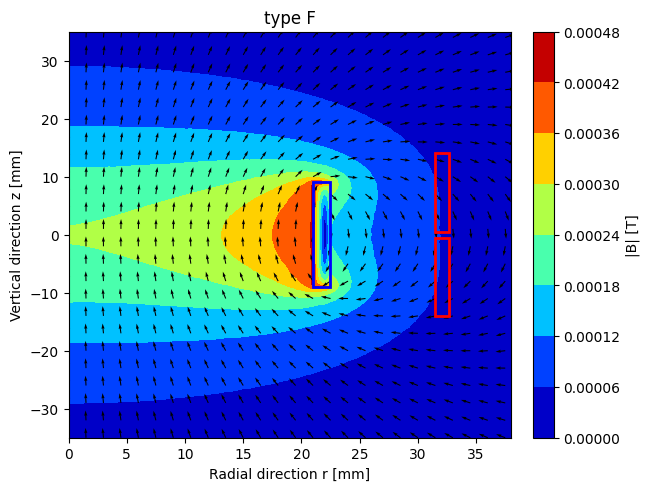

In [7]:
%matplotlib inline
# Call the plotting function from MakeBfield
MakeBfield.plot_b_field('typeF_dr_1_dz_01_Mesh_0.005', n_quiver_z=300, coil_type='F', shift_z=0)
# Adjust plot
plt.xlabel("Radial direction r [mm]")
plt.ylabel("Vertical direction z [mm]")
plt.title("type F")
#plt.ylim([0,45])

plt.show(block=False)

**The flux of a single coil layer can be computed by integrating the generated magnetic field using the command compute_asymm_flux(x_offset, d_theta, lvdt_type, load_filename, save_filename, radius (optional, if different from lvdt_type)). The x_offset variable denotes the transversal offset of the inner coil. The stepsize for the angular integration is specified with d_theta and the LVDT design from the "feed.py" script by lvdt_type string.  The magnetic field data is taken from the load_filename, this should be the same name as the save_filename used in "MakeBfield.make_b_field2()", i.e. typeF_dr_1_dz_01_Mesh_0.005.**

The flux is computed on the basis of the asymmetric method explained in section 3.4 in the thesis, specifically equation (3.20) is used. You can find the algorithm to achieve this computation in the "asymm_circle_flux_polar()" command in the "MakeBfield.py" script.

In [ ]:
MakeBfield.compute_asymm_flux(1, 0.001, "F_out_1layer", 'typeF_dr_1_dz_01_Mesh_0.005', 'typeF_dr_1_dz_01_asymm_x1_dtheta01')

**The flux data can be conveniently plotted using the MakeBfield.return_flux_vec(save_filename) command to return the z vector and phi vector.**

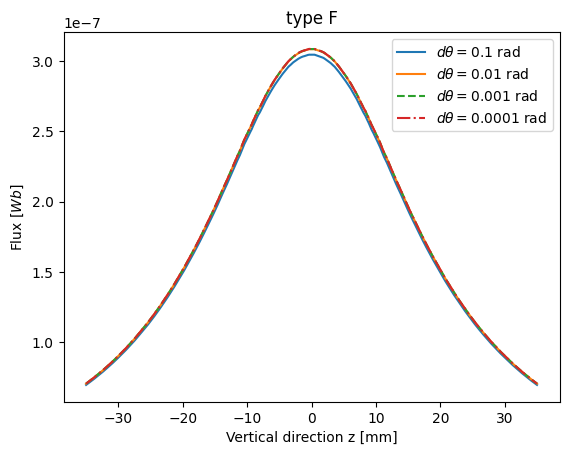

In [4]:
# Plot the flux for varying values of d_theta for no transversal offset (x0)
%matplotlib inline

z_vec, phi_vec = MakeBfield.return_flux_vec(filename='typeF_dr_1_dz_01_asymm_x0_dtheta1')
z_vec2, phi_vec2 = MakeBfield.return_flux_vec(filename='typeF_dr_1_dz_01_asymm_x0_dtheta01')
z_vec3, phi_vec3 = MakeBfield.return_flux_vec(filename='typeF_dr_1_dz_01_asymm_x0_dtheta001')
z_vec4, phi_vec4 = MakeBfield.return_flux_vec(filename='typeF_dr_1_dz_01_asymm_x0_dtheta0001')

plt.plot(z_vec, phi_vec, label=r'$d\theta = 0.1$ rad')
plt.plot(z_vec2, phi_vec2, label=r'$d\theta = 0.01$ rad')
plt.plot(z_vec3, phi_vec3, label=r'$d\theta = 0.001$ rad', linestyle='dashed')
plt.plot(z_vec4, phi_vec4, label=r'$d\theta = 0.0001$ rad', linestyle='dashdot')

plt.xlabel('Vertical direction z [mm]')
plt.ylabel(r'Flux [$Wb$]')
plt.title('type F')
plt.legend()
#plt.xlim([-30,-10])
#plt.ylim([0.1e-6,0.25e-6])

**Finally, the voltage can be computed using compute_voltages_disc(z_max, lvdt_type, load_filename, save_filename, wire_type: str = "32 AWG"). The variable z_max shows the range over which the outer coils can probe: [-z_max, z_max] = [z bottom LOC, z top UOC]**

This command computes the voltage by summing the voltage in each coil, see equation (3.22) and Figure 3.9 in the thesis.

In [ ]:
MakeBfield.compute_voltages_disc(34, "F_out_1layer", 'typeF_dr_1_dz_01_asymm_x1_dtheta01', 'typeF_dr_1_dz_01_asymm_x1_dtheta01_disc')

**The computed voltage data can be analysed by loading the saved data**

C:\Users\michi\AppData\Local\Temp\ipykernel_3016\1646458351.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pos, 50*(np.flipud(manualFdisc["v_upp"][indices]) - manualFdisc["v_low"][indices]), 'o-', label='1st layer', linestyle='dotted', markerfacecolor='none')
C:\Users\michi\AppData\Local\Temp\ipykernel_3016\1646458351.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pos, 50*(np.flipud(manualFdisc5th["v_upp"][indices]) - manualFdisc5th["v_low"][indices]), 'o-', label='5th layer', linestyle='dotted', markerfacecolor='none')


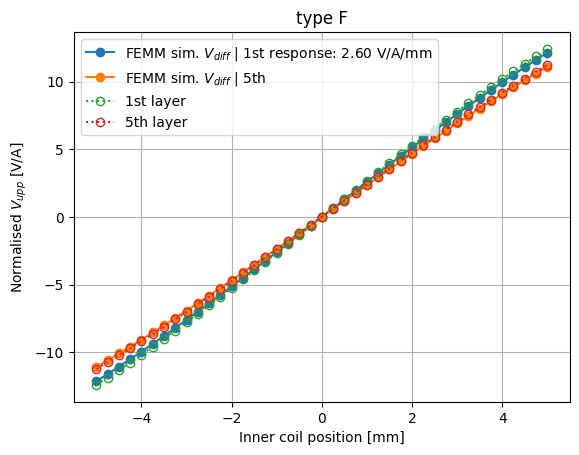

In [6]:
# Comparison between FEMM and manual/custom algorithm for the voltage in the 1st and 5th layer

# custom algorithm data
manualFdisc = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_1layer_symm_disc'+'.npz')
manualFdisc5th = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_asymm_x0_dtheta01_5thlayer_disc'+'.npz')

# FEMM sim data
layer_1st_windingF = np.load('../dataMap/FEMM_data/'+ 'typeF_40steps_025dz_5shift_1layer'+'.npz')
layer_5th_windingF = np.load('../dataMap/FEMM_data/'+ 'typeF_40steps_025dz_5shift_5thlayer'+'.npz')


plt.plot(layer_1st_windingF["IC_positions"], 50*(abs(layer_1st_windingF["UOC_voltages"])-abs(layer_1st_windingF["LOC_voltages"])), 'o-', label=r'FEMM sim. $V_{diff}$ | 1st response: 2.60 V/A/mm')
plt.plot(layer_5th_windingF["IC_positions"], 50*(abs(layer_5th_windingF["UOC_voltages"])-abs(layer_5th_windingF["LOC_voltages"])), 'o-', label=r'FEMM sim. $V_{diff}$ | 5th')

# Select the data points of the FEMM data at the same z positions as the manual algorithm (allows for the division of data, i.e. (Manual-FEMM)/FEMM to compare the relative deviation of the two methods)
xSub = manualFdisc["z_vec"]
pos = layer_5th_windingF["IC_positions"]
# Find the indices where x matches the positions in pos
indices = np.searchsorted(xSub, pos)

# Differential outer coil voltage found by subtracting LOC voltage from UOC voltage similar to FEMM
plt.plot(pos, 50*(np.flipud(manualFdisc["v_upp"][indices]) - manualFdisc["v_low"][indices]), 'o-', label='1st layer', linestyle='dotted', markerfacecolor='none')
plt.plot(pos, 50*(np.flipud(manualFdisc5th["v_upp"][indices]) - manualFdisc5th["v_low"][indices]), 'o-', label='5th layer', linestyle='dotted', markerfacecolor='none')

plt.legend(loc='upper left')
#plt.xlim([-5,5])
#plt.ylim([-20,20])
plt.xlabel('Inner coil position [mm]')
plt.ylabel(r'Normalised $V_{upp}$ [V/A]')
plt.title('type F')
plt.grid()

**However, the previous code only simulated LVDTs with one layer. It is possible to simulate multiple layers individually and combine the fluxes to get the total flux manually. The command MakeBfield.compute_asymm_flux_layers_par() provides a more convenient solution by parallel processing the asymmetric flux computation for multiple coils layers. Unfortunately I have only figured out how to run parallel computation in conventional .py python scripts, see "exercises.py" for examples starting from line 38 "### Code for simulating multiple layers, while also looping over varying transversal offset" . Be warned that this command is quite computationally intensive for d_theta =< 0.001 and might take several minutes up to north of 40 min to run depending on the parameters.**

**Furthermore, beneath the parallel flux computation loop in "exercises.py" the code for looping the voltage computation of varying transversal offsets is found starting from line 48.**

**Similarly to the previous notebook cell, the data can be analysed while also looping over varying transversal offsets for convenience. The MakeBfield.fit_slope() command is used to retrieve the response (slope) by fitting the outer coil signal over the specified range.**

the fitted slope m: 3.286222580443647
the fitted slope m: 3.286683971289151
the fitted slope m: 3.2975826768784056
the fitted slope m: 3.318999873220132
the fitted slope m: 3.4076763373230143
the fitted slope m: 3.5003535056026274
the fitted slope m: 3.4967672526896574


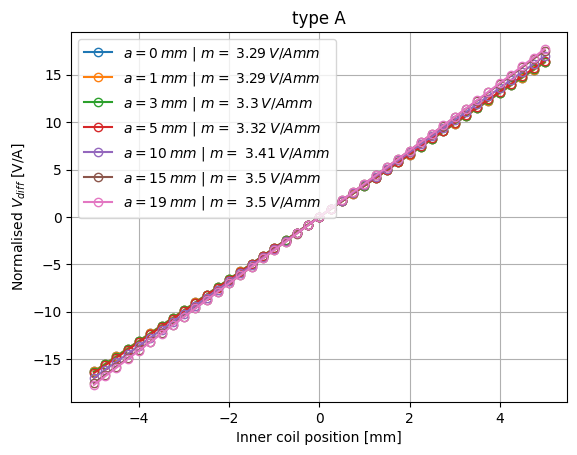

In [10]:
from MakeBfield import fit_slope, fit_slope_dev, indx_closest
from scipy.optimize import curve_fit

# load data for indices search (see next comment)
layer_5_windingtotF = np.load('../dataMap/FEMM_data/'+ 'typeF_40steps_025dz_5shift_5layers'+'.npz')
manualF_asymm_0_5lay = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_asymm_x0_dtheta01_5layers_Tot_disc'+'.npz')
layer_5_windingtotA = np.load('../dataMap/FEMM_data/'+ 'typeA_40steps_025dz_5shift_5layers'+'.npz')
manualA_asymm_0_5lay = np.load('../dataMap/voltages/'+ 'typeA_dr_1_dz_01_asymm_x0_dtheta001_5layers_full_Tot_disc'+'.npz')

# Select the data points of the FEMM data at the same z positions as the manual algorithm (allows for the division of data, i.e. (Manual-FEMM)/FEMM to compare the relative deviation of the two methods)

# type F data
# xSub = manualF_asymm_0_5lay["z_vec"]
# pos = layer_5_windingtotF["IC_positions"]

# type A data
xSub = manualA_asymm_0_5lay["z_vec"]
pos = layer_5_windingtotA["IC_positions"]

# Find the indices where x matches the positions in pos
indices = np.searchsorted(xSub, pos)

# define fit range [-f_range, f_range]
f_range = 1
# transversal offset vectors to loop over
F_off = [0,1,3,5,6]
A_off = [0,1,3,5,10,15,19]
# initialisation of data vectors
pos_vec = []
v_vec = []
resp_vec = []
fit_vec = []
slope_vec = []
# loop over the transversal offsets
for a in A_off:
    # data for type A
    data_i = np.load('../dataMap/voltages/'+ 'typeA_dr_1_dz_01_asymm_x' + str(a) +'_dtheta001_5layers_full_Tot_disc'+'.npz')
    # data for type F
    #data_i = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_asymm_x' + str(a) +'_dtheta01_5layers_Tot_disc'+'.npz')
    # compute the differential voltage
    y_response_i = 50*(np.flipud(data_i["v_upp"][indices])-data_i["v_low"][indices])
    # make a linear to compute the response (slope)
    p_i, m_i = fit_slope(pos,y_response_i,-f_range,f_range, returnF=True)
    # append data
    resp_vec.append(y_response_i)
    fit_vec.append(p_i(pos))
    slope_vec.append(m_i)
    plt.plot(pos,y_response_i, 'o-', markerfacecolor='none', label=r'$a=$' + str(a) + r'$\:mm$ | $m=$ ' +str(round(m_i,2)) + r'$\:V/Amm$' )

#plt.xlim([3,5])
#plt.ylim([9,20])
plt.legend(loc='upper left')
plt.xlabel('Inner coil position [mm]')
plt.ylabel(r'Normalised $V_{diff}$ [V/A]')
plt.title('type A')
plt.grid()

**The relative response deviation is visualised via:**

C:\Users\michi\AppData\Local\Temp\ipykernel_3016\3076833856.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(A_off, devTrans, 'o-', linestyle='dashed')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


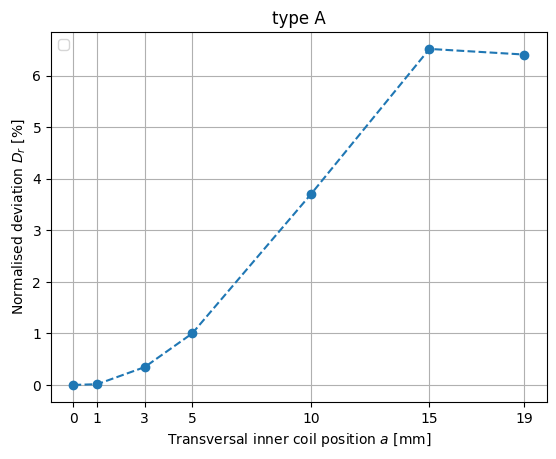

In [11]:
F_off = [0,1,3,5,6]
A_off = [0,1,3,5,10,15,19]
devTrans = 100*(slope_vec-slope_vec[0])/slope_vec[0]
plt.plot(A_off, devTrans, 'o-', linestyle='dashed')
plt.legend(loc='upper left')
#plt.xlim([0.5,5])
#plt.ylim([0,70])
plt.xlabel('Transversal inner coil position $a$ [mm]')
plt.ylabel(r'Normalised deviation $D_r$ [%]')
plt.xticks(A_off)
plt.title('type A')
plt.grid()

**If desired the data can be saved as**

In [ ]:
np.savez('../dataMap/TransDev/TypeA', Trans_off=A_off, dev_trans=devTrans)

**The nonlinearity for varying transversal offsets can also easily be found by the following script**

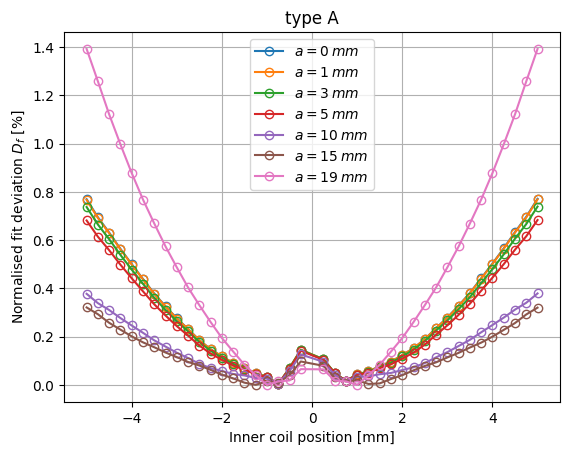

In [14]:
from MakeBfield import fit_slope

# load data for indices search (see next comment)
layer_5_windingtotF = np.load('../dataMap/FEMM_data/'+ 'typeF_40steps_025dz_5shift_5layers'+'.npz')
manualF_asymm_0_5lay = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_asymm_x0_dtheta01_5layers_Tot_disc'+'.npz')
layer_5_windingtotA = np.load('../dataMap/FEMM_data/'+ 'typeA_40steps_025dz_5shift_5layers'+'.npz')
manualA_asymm_0_5lay = np.load('../dataMap/voltages/'+ 'typeA_dr_1_dz_01_asymm_x0_dtheta001_5layers_full_Tot_disc'+'.npz')

# Select the data points of the FEMM data at the same z positions as the manual algorithm (allows for the division of data, i.e. (Manual-FEMM)/FEMM to compare the relative deviation of the two methods)

# type F data
# xSub = manualF_asymm_0_5lay["z_vec"]
# pos = layer_5_windingtotF["IC_positions"]

# type A data
xSub = manualA_asymm_0_5lay["z_vec"]
pos = layer_5_windingtotA["IC_positions"]

# Find the indices where x matches the positions in pos
indices = np.searchsorted(xSub, pos)

# transversal offset vectors to loop over
F_off = [0,1,3,5,6]
A_off = [0,1,3,5,10,15,19]
# do not compute the relative deviation in the [-d, d] domain to avoid division by small numbers,
# resulting in numerical instabilities
d = 0.1
# loop over the transversal offsets
for i in range(0,len(A_off)):
    dev_i = abs((fit_vec[i] -  resp_vec[i])/fit_vec[i])
    plt.plot(pos[abs(pos) > d],100*dev_i[abs(pos) > d], 'o-', markerfacecolor='none', label=r'$a=$' + str(A_off[i]) + r'$\:mm$' )
plt.legend(loc='upper center')
#plt.xlim([0.5,5])
#plt.ylim([0,1.5])
plt.xlabel('Inner coil position [mm]')
plt.ylabel(r'Normalised fit deviation $D_f$ [%]')
plt.title('type A')
plt.grid()

**The change in differential outer coil voltage for a given z height is visualised by the following notebook cell**
See page 36 in the thesis for additional information.

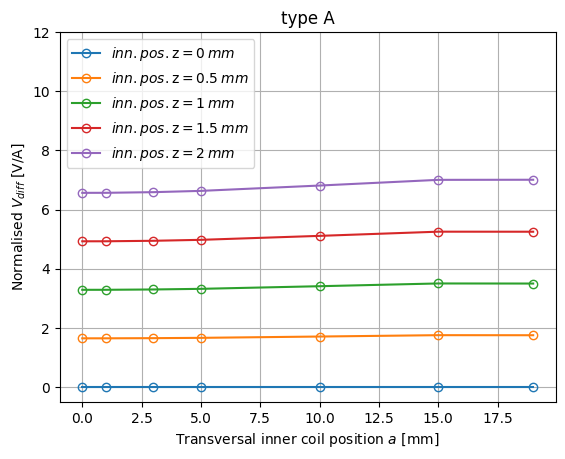

In [9]:
layer_5_windingtotF = np.load('../dataMap/FEMM_data/'+ 'typeF_40steps_025dz_5shift_5layers'+'.npz')
manualF_asymm_0_5lay = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_asymm_x0_dtheta01_5layers_Tot_disc'+'.npz')
layer_5_windingtotA = np.load('../dataMap/FEMM_data/'+ 'typeA_40steps_025dz_5shift_5layers'+'.npz')
manualA_asymm_0_5lay = np.load('../dataMap/voltages/'+ 'typeA_dr_1_dz_01_asymm_x0_dtheta001_5layers_full_Tot_disc'+'.npz')

# type A
xSub = manualA_asymm_0_5lay["z_vec"]
# type F
#xSub = manualF_asymm_0_5lay["z_vec"]

# z position vec to evaluate
z_pos = [0, 0.5, 1, 1.5, 2]
# transversal offset vectors to loop over
F_off = [0,1,3,5,6]
A_off = [0,1,3,5,10,15,19]
# choose the offset vec
off_vec = A_off
# initialisation of data vec
pos_vec = []
v_vec = []
curve_vec = []
# loop over z positions
for z in z_pos:
    v_z = []
    cond = xSub == z
    for a in off_vec:
        # type A data
        data_i = np.load('../dataMap/voltages/'+ 'typeA_dr_1_dz_01_asymm_x' + str(a) +'_dtheta001_5layers_full_Tot_disc'+'.npz')
        # type F data
        #data_i = np.load('../dataMap/voltages/'+ 'typeF_dr_1_dz_01_asymm_x' + str(a) +'_dtheta01_5layers_Tot_disc'+'.npz')
        # differential outer coil voltage
        y_response_i = 50*(np.flipud(data_i["v_upp"])-data_i["v_low"])
        v_z.append(np.extract(cond,y_response_i))
    curve_vec.append(v_z)
    plt.plot(off_vec,v_z, 'o-', markerfacecolor='none', label=r'$inn. pos. $z$=$' + str(z) + r'$\:mm$' )
plt.legend(loc='upper left')
# plt.xlim([0,5])
plt.ylim([-0.5,12])
#plt.ylim([-2,45])
plt.xlabel('Transversal inner coil position $a$ [mm]')
plt.ylabel(r'Normalised $V_{diff}$ [V/A]')
plt.title('type A')
plt.grid()

**Save data if desired**

In [ ]:
np.savez('../dataMap/TransDev/TypeA_transVecs', Trans_off=A_off, V_trans=curve_vec, z_pos=z_pos)

**Finally, the mimicked height is visualised**

See page 37 and equation (3.28) in the thesis.

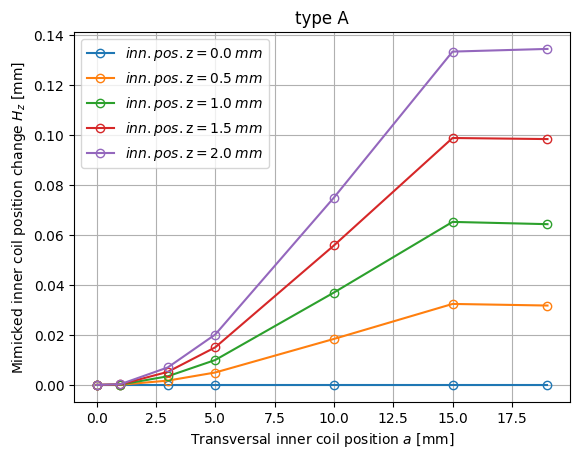

In [8]:
# load data
F_data = np.load('../dataMap/TransDev/TypeF_transVecs.npz')
A_data = np.load('../dataMap/TransDev/TypeA_transVecs.npz')
# choose which data to plot
data = A_data
height = data['z_pos']
# set the slope in case of no transversal offset a=0
m = 3.29 # type A
#m = 12.57 # type F
# loop over all z positions
for i in range(len(height)):
    imiHeight = (data['V_trans'][i] - data['V_trans'][i][0])/m
    plt.plot(data['Trans_off'], imiHeight,'o-', markerfacecolor='none', label=r'$inn. pos. $z$=$' + str(height[i]) + r'$\:mm$')
plt.legend(loc='upper left')
# plt.xlim([0,5])
# plt.ylim([0,70])
plt.xlabel('Transversal inner coil position $a$ [mm]')
plt.ylabel(r'Mimicked inner coil position change $H_z$ [mm]')
plt.title('type A')
plt.grid()

**It should be noted that there are many optional arguments in the shown commands which were not mentioned here. Most of the time these options should not be changed, but if required the underlying code can be checked in the "MakeBfield.py" script with additional comments of the inner workings of the code.**

Simply hovering your cursor over the given command will also show a concise description of its function.